## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [5]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [6]:
# TODO: 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
        
    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """

    images = []
    labels = []

    if "test" in set_dir:
        # Load test images in filename order
        for filename in sorted(os.listdir(set_dir), key=lambda x: int(x.split('.')[0])):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(set_dir, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
    else:
        # Load train/val images with labels
        for label in sorted(os.listdir(set_dir)):
            label_dir = os.path.join(set_dir, label)
            if os.path.isdir(label_dir):
                for filename in os.listdir(label_dir):
                    if filename.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(label_dir, filename)
                        img = cv2.imread(img_path)
                        if img is not None:
                            images.append(img)
                            labels.append(label)

    return images, labels

In [7]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images
        
    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions
        
    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32
        
    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if not images:
        return np.array([])

    processed_images = []
    for img in tqdm(images, desc="Resizing images"):
        h, w, c = img.shape
        if c != 3:
            raise ValueError(f"Invalid number of channels: {c}. Expected 3.")

        # 1. Resize based on the shortest edge
        if h < w:
            new_h = target_size
            new_w = int(w * (target_size / h))
        else:
            new_w = target_size
            new_h = int(h * (target_size / w))

        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # 2. Center crop
        h, w, _ = resized_img.shape
        start_x = (w - target_size) // 2
        start_y = (h - target_size) // 2

        cropped_img = resized_img[start_y:start_y + target_size, start_x:start_x + target_size]

        # Ensure the cropped image has the exact target size
        if cropped_img.shape[0] != target_size or cropped_img.shape[1] != target_size:
            cropped_img = cv2.resize(cropped_img, (target_size, target_size), interpolation=cv2.INTER_AREA)

        processed_images.append(cropped_img)

    return np.array(processed_images)


In [8]:
# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

In [9]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

Resizing images: 100%|██████████| 2600/2600 [00:02<00:00, 1089.56it/s]


In [10]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

print(f"Train images: {len(images_train)}, Train labels: {len(labels_train)}")
print(f"Val images: {len(images_val)}, Val labels: {len(labels_val)}")
print(f"Test images: {len(images_test)}")

# Check the shape and data type of the images
print(f"Train images shape: {images_train.shape}")
print(f"Val images shape: {images_val.shape}")
print(f"Test images shape: {images_test.shape}")
print(f"Data type: {images_train.dtype}")
print(f"Value range: [{images_train.min():.3f}, {images_train.max():.3f}]")

Train images: 7800, Train labels: 7800
Val images: 2600, Val labels: 2600
Test images: 2600
Train images shape: (7800, 224, 224, 3)
Val images shape: (2600, 224, 224, 3)
Test images shape: (2600, 224, 224, 3)
Data type: float32
Value range: [0.000, 1.000]


In [11]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.from_numpy(images_train.transpose(0, 3, 1, 2))
tensor_val = torch.from_numpy(images_val.transpose(0, 3, 1, 2))
tensor_test = torch.from_numpy(images_test.transpose(0, 3, 1, 2))

In [12]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

# Standardized calculations
train_mean = tensor_train.mean(dim=(0, 2, 3), keepdim=True)
train_std = tensor_train.std(dim=(0, 2, 3), keepdim=True)

# Numerical stability check
print(f"Train mean shape: {train_mean.shape}")
print(f"Train std shape: {train_std.shape}")
print(f"Train std values: {train_std.flatten()}")

# Ensure that the standard deviation is not zero
tensor_train = (tensor_train - train_mean) / (train_std + 1e-7)
tensor_val = (tensor_val - train_mean) / (train_std + 1e-7)
tensor_test = (tensor_test - train_mean) / (train_std + 1e-7)

Train mean shape: torch.Size([1, 3, 1, 1])
Train std shape: torch.Size([1, 3, 1, 1])
Train std values: tensor([0.2827, 0.2591, 0.2707])


In [13]:
# TODO: 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.

if not os.path.exists("../data_preprocessed"):
    os.makedirs("../data_preprocessed")
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt", pickle_protocol=5)
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt", pickle_protocol=5)
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt", pickle_protocol=5)


# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }

def get_unique_labels(train_dir):
    """Get sorted category name from the training set folder"""
    return sorted([name for name in os.listdir(train_dir)
                   if os.path.isdir(os.path.join(train_dir, name))])


# Replace hard-coded category list
unique_labels = get_unique_labels("../dataset_split/train")
label_to_index = {label: index for index, label in enumerate(unique_labels)}

print(f"Unique labels: {unique_labels}")
print(f"Number of classes: {len(unique_labels)}")

# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[label] for label in labels_train], dtype=torch.long)
labels_val_index = torch.tensor([label_to_index[label] for label in labels_val], dtype=torch.long)

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, "../data_preprocessed/labels_train.pt")
torch.save(labels_val_index, "../data_preprocessed/labels_val.pt")
index_to_label = {v: k for k, v in label_to_index.items()}
torch.save(index_to_label, "../data_preprocessed/index_to_label.pt")

Unique labels: ['african_elephant', 'airliner', 'banana', 'convertible_car', 'golden_retriever', 'goldfish', 'parachute', 'rugby', 'sunglasses', 'tiger_cat']
Number of classes: 10


In [14]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("../data_preprocessed/tensor_train.pt", weights_only=False)
tensor_val = torch.load("../data_preprocessed/tensor_val.pt", weights_only=False)
tensor_test = torch.load("../data_preprocessed/tensor_test.pt", weights_only=False)

labels_train_index = torch.load("../data_preprocessed/labels_train.pt")
labels_val_index = torch.load("../data_preprocessed/labels_val.pt")

# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [15]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [16]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH = 10
INIT_LR = 0.01
BATCH_SIZE = 200

# Specify the training device (automatically detects GPU if available)
# Usage example: 
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# TODO: 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)

# 2.2 Modify the output layer so that the model aligns with this project.
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)

# 2.3 Move the model to selected device.
resnet34 = resnet34.to(device)

In [18]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification

In [19]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.
from tqdm import trange

train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []
best_val_acc = 0.0

# Early stopping parameters
patience = 3
patience_counter = 0
min_delta = 0.001

for epoch in trange(MAX_EPOCH, desc="Training ResNet34"):
    # Clear the CUDA cache to free up memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    resnet34.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for i in range(0, len(tensor_train), BATCH_SIZE):
        inputs = tensor_train[i:i + BATCH_SIZE].to(device)
        labels = labels_train_index[i:i + BATCH_SIZE].to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = resnet34(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_losses_resnet34.append(train_loss / len(tensor_train))
    train_accs_resnet34.append(train_acc)

    # Validation phase
    resnet34.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i in range(0, len(tensor_val), BATCH_SIZE):
            inputs_val = tensor_val[i:i + BATCH_SIZE].to(device)
            labels_val = labels_val_index[i:i + BATCH_SIZE].to(device)

            outputs_val = resnet34(inputs_val)  # Forward pass
            loss_val = criterion(outputs_val, labels_val)  # Compute loss

            val_loss += loss_val.item() * inputs_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

    val_acc = correct_val / total_val
    val_losses_resnet34.append(val_loss / len(tensor_val))
    val_accs_resnet34.append(val_acc)

    print(f"Epoch [{epoch + 1}/{MAX_EPOCH}], "
          f"Train Loss: {train_losses_resnet34[-1]:.4f}, Train Acc: {train_accs_resnet34[-1]:.4f}, "
          f"Val Loss: {val_losses_resnet34[-1]:.4f}, Val Acc: {val_accs_resnet34[-1]:.4f}")

    # Save the model with the best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        if not os.path.exists("../models"):
            os.makedirs("../models")
        torch.save(resnet34, "../models/resnet34_checkpoint.pkl")
        print(f"Saved best model with validation accuracy: {best_val_acc:.4f}")

    # Early stopping logic
    if epoch > 0 and len(val_accs_resnet34) > 1:
        if val_accs_resnet34[-1] - val_accs_resnet34[-2] < min_delta:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
        else:
            patience_counter = 0

    # Update the learning rate scheduler
    scheduler.step()  # Step the learning rate scheduler

Training ResNet34:  10%|█         | 1/10 [01:43<15:33, 103.73s/it]

Epoch [1/10], Train Loss: 3.6242, Train Acc: 0.0781, Val Loss: 2.3137, Val Acc: 0.0919
Saved best model with validation accuracy: 0.0919


Training ResNet34:  20%|██        | 2/10 [03:29<13:57, 104.65s/it]

Epoch [2/10], Train Loss: 2.3393, Train Acc: 0.0064, Val Loss: 2.9692, Val Acc: 0.0950
Saved best model with validation accuracy: 0.0950


Training ResNet34:  30%|███       | 3/10 [05:15<12:17, 105.37s/it]

Epoch [3/10], Train Loss: 2.3472, Train Acc: 0.0000, Val Loss: 2.3120, Val Acc: 0.0985
Saved best model with validation accuracy: 0.0985


Training ResNet34:  40%|████      | 4/10 [07:01<10:34, 105.69s/it]

Epoch [4/10], Train Loss: 2.3093, Train Acc: 0.0995, Val Loss: 2.3193, Val Acc: 0.0977


Training ResNet34:  50%|█████     | 5/10 [08:46<08:48, 105.62s/it]

Epoch [5/10], Train Loss: 2.3085, Train Acc: 0.1000, Val Loss: 2.3163, Val Acc: 0.0977


Training ResNet34:  50%|█████     | 5/10 [10:31<10:31, 126.26s/it]

Epoch [6/10], Train Loss: 2.3082, Train Acc: 0.1000, Val Loss: 2.3144, Val Acc: 0.0973
Early stopping triggered at epoch 6


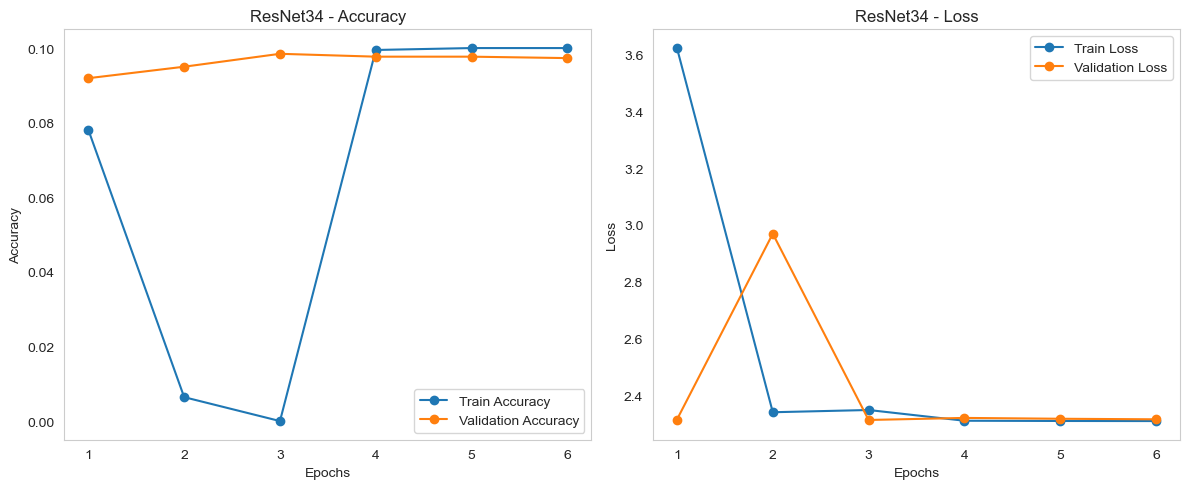

In [20]:
# TODO: 5. Plot the loss and accuracy curves.

def plot_curves(train_accs, train_losses, val_accs, val_losses, title):
    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accs, label='Validation Accuracy', marker='o')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


plot_curves(train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34, "ResNet34")

# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [21]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [22]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 10
INIT_LR = 0.01
BATCH_SIZE = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 2.0  # Temperature for softmax in knowledge distillation
LOSS_RATIO = 0.5  # Ratio between student loss and teacher loss

In [23]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

resnet18 = torchvision.models.resnet18(weights=None)  # Non-pretrained ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)  # Move to device

In [24]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = torch.load("../models/resnet34_checkpoint.pkl", weights_only=False)
resnet34 = resnet34.to(device)  # Move to device
resnet34.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet18.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler

In [26]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

# Defining knowledge distillation loss function
def distillation_loss(student_outputs, teacher_outputs, true_labels, temperature, ratio):
    """
    Knowledge distillation loss function
    """
    # Hard loss (student predictions vs true labels)
    hard_loss = F.cross_entropy(student_outputs, true_labels)

    # Soft loss (student predictions vs teacher predictions)
    student_soft = F.log_softmax(student_outputs / temperature, dim=1)
    teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)
    soft_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean') * (temperature ** 2)

    # Combined loss
    return ratio * hard_loss + (1 - ratio) * soft_loss


# Training loop
train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []
best_val_acc = 0.0

for epoch in trange(MAX_EPOCH, desc="Training ResNet18"):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    resnet18.train()
    resnet34.eval()  # Make sure the teacher model is in evaluation mode

    train_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for i in range(0, len(tensor_train), BATCH_SIZE):
        inputs = tensor_train[i:i + BATCH_SIZE].to(device)
        labels = labels_train_index[i:i + BATCH_SIZE].to(device)

        optimizer.zero_grad()

        # Forward communication of student models
        student_outputs = resnet18(inputs)

        # Forward propagation of teacher models (no gradient calculation)
        with torch.no_grad():
            teacher_outputs = resnet34(inputs)

        # Calculate knowledge distillation loss
        loss = distillation_loss(student_outputs, teacher_outputs, labels, TEMPERATURE, LOSS_RATIO)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(student_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_losses_resnet18.append(train_loss / len(tensor_train))
    train_accs_resnet18.append(train_acc)

    # Verification phase
    resnet18.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i in range(0, len(tensor_val), BATCH_SIZE):
            inputs_val = tensor_val[i:i + BATCH_SIZE].to(device)
            labels_val = labels_val_index[i:i + BATCH_SIZE].to(device)

            student_outputs_val = resnet18(inputs_val)
            teacher_outputs_val = resnet34(inputs_val)

            loss_val = distillation_loss(student_outputs_val, teacher_outputs_val, labels_val, TEMPERATURE, LOSS_RATIO)

            val_loss += loss_val.item() * inputs_val.size(0)
            _, predicted_val = torch.max(student_outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

    val_acc = correct_val / total_val
    val_losses_resnet18.append(val_loss / len(tensor_val))
    val_accs_resnet18.append(val_acc)

    print(f"Epoch [{epoch + 1}/{MAX_EPOCH}], "
          f"Train Loss: {train_losses_resnet18[-1]:.4f}, Train Acc: {train_accs_resnet18[-1]:.4f}, "
          f"Val Loss: {val_losses_resnet18[-1]:.4f}, Val Acc: {val_accs_resnet18[-1]:.4f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet18, "../models/resnet18_checkpoint.pkl")
        print(f"Saved best model with validation accuracy: {best_val_acc:.4f}")

    scheduler.step()

Training ResNet18:  10%|█         | 1/10 [01:19<11:56, 79.56s/it]

Epoch [1/10], Train Loss: 1.7620, Train Acc: 0.1437, Val Loss: 1.3080, Val Acc: 0.1077
Saved best model with validation accuracy: 0.1077


Training ResNet18:  20%|██        | 2/10 [02:41<10:47, 80.96s/it]

Epoch [2/10], Train Loss: 1.1860, Train Acc: 0.0387, Val Loss: 1.2562, Val Acc: 0.0812


Training ResNet18:  30%|███       | 3/10 [04:03<09:30, 81.55s/it]

Epoch [3/10], Train Loss: 1.1753, Train Acc: 0.0631, Val Loss: 1.2056, Val Acc: 0.1200
Saved best model with validation accuracy: 0.1200


Training ResNet18:  40%|████      | 4/10 [05:27<08:14, 82.47s/it]

Epoch [4/10], Train Loss: 1.1798, Train Acc: 0.0974, Val Loss: 3.2472, Val Acc: 0.1262
Saved best model with validation accuracy: 0.1262


Training ResNet18:  50%|█████     | 5/10 [06:52<06:56, 83.35s/it]

Epoch [5/10], Train Loss: 1.2047, Train Acc: 0.0000, Val Loss: 1.1711, Val Acc: 0.0935


Training ResNet18:  60%|██████    | 6/10 [08:16<05:33, 83.49s/it]

Epoch [6/10], Train Loss: 1.1677, Train Acc: 0.0997, Val Loss: 1.1579, Val Acc: 0.0954


Training ResNet18:  70%|███████   | 7/10 [09:40<04:11, 83.72s/it]

Epoch [7/10], Train Loss: 1.1618, Train Acc: 0.0999, Val Loss: 1.1571, Val Acc: 0.0965


Training ResNet18:  80%|████████  | 8/10 [11:04<02:47, 83.71s/it]

Epoch [8/10], Train Loss: 1.1602, Train Acc: 0.1010, Val Loss: 1.1567, Val Acc: 0.0965


Training ResNet18:  90%|█████████ | 9/10 [12:29<01:24, 84.15s/it]

Epoch [9/10], Train Loss: 1.1596, Train Acc: 0.0785, Val Loss: 1.1565, Val Acc: 0.0996


Training ResNet18: 100%|██████████| 10/10 [13:51<00:00, 83.11s/it]

Epoch [10/10], Train Loss: 1.1592, Train Acc: 0.0494, Val Loss: 1.1563, Val Acc: 0.0912


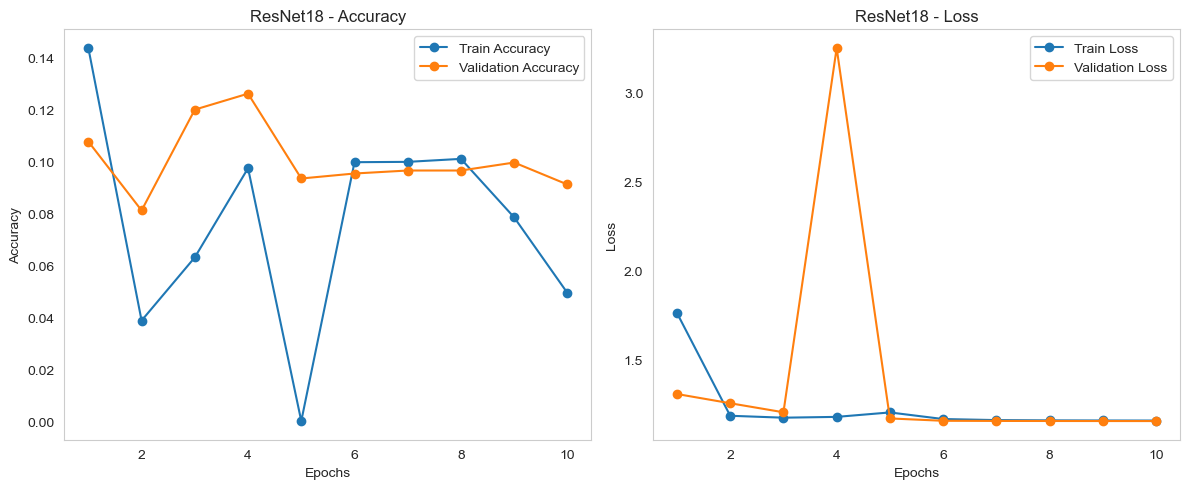

In [27]:
# TODO: 6. Plot the loss and accuracy curves.

plot_curves(train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18, "ResNet18")

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [28]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = torch.load("../models/resnet18_checkpoint.pkl", weights_only=False)
resnet18 = resnet18.to(device)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []
resnet18.eval()

with torch.no_grad():
    for i in trange(0, len(tensor_test), BATCH_SIZE, desc="Predicting"):
        inputs = tensor_test[i:i + BATCH_SIZE].to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

print(f"Total predictions: {len(predictions)}")

Predicting: 100%|██████████| 13/13 [00:01<00:00,  8.54it/s]

Total predictions: 2600


In [30]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = torch.load("../data_preprocessed/index_to_label.pt")

with open("submission.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["file_name", "label"])

    for i, pred in enumerate(predictions):
        label = index_to_label[pred]
        writer.writerow([f"{i}.jpg", label])

print("Submission file created")
print(f"Generated {len(predictions)} predictions")

Submission file created
Generated 2600 predictions
